# Localization with a known map  - Tutorial: Part 2

Localization with a known map, where the map is given as family of line segments. Moreover we optionally allow the environment to be clutterd with additional boxes, which are not mapped. We refer to such a map as _idealized_.

In [3]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [4]:
include("src/localization_part_1.jl")
include("src/localization_part_2.jl")

Loading `../data/data_4.jld2` ...

	_segs      Vector{Segment}
	_boxes     Vector{Segment}
	_center    Vector{Float64}
	_xs        Vector{Vector{Float64}}
	_hds       Vector{Float64}
	_ps        Vector{Pose}
	_dxs       Vector{Vector{Float64}}
	_dhds      Vector{Float64}
	_us        Vector{Control}
	_T         Int64
_segs_   CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}
_boxes_  CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}
_ps_     CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}
_as_     CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}

_fov     Float64
_as      Vector{Float64}
_zs      Vector{Vector{Float64}}
_ys      Vector{Vector{Vector{Float64}}}


plot_slam_trace! (generic function with 1 method)

In [5]:
#nbx
function get_offset(v0, k, r)
    center = (r + k.*r)/2
    return v0 - center
end


function first_grid_vec(v0::Vector{Real}, k::Vector{Int}, r::Vector{Real})
    return r + get_offset(v0, k, r) 
end

"""
    vs, ls = vector_grid(v0, k, r)

Returns grid of vectors and their linear indices, given 
a grid center, numnber of grid points along each dimension and
the resolution along each dimension.
"""
function vector_grid(v0::Vector{Float64}, k::Vector{Int}, r::Vector{Float64})
    # Todo: Does it make sense to get a CUDA version of this?
    offset = get_offset(v0, k, r)
    
    shape = Tuple(k)
    cs = CartesianIndices(shape)
    ls = LinearIndices(shape)
    vs = map(I -> [Tuple(I)...].*r + offset, cs);
    return (vs=vs, linear_indices=ls)
end

grid_index(x, v0, k, r) = quantize(x, r, zero=get_offset(v0, k, r));

In [13]:
#nbx
"""
    log_ps, ps = eval_pose_vectors(
                    ps_::CuArray,
                    x::Matrix, 
                    ys_::CuArray, as_::CuArray, w::Int, 
                    s_noise::Float64, outlier::Float64, 
                    outlier_vol::Float64=1.0, zmax::Float64=100.0; sorted=false)

Evaluates a collection of poses 
with respect to different Gaussian mixtures...
"""
function eval_pose_vectors(
            ps_::CuArray,
            x_::CuArray, 
            segs, as, w::Int, 
            s_noise::Float64, outlier::Float64, outlier_vol::Float64=1.0, 
            zmax::Float64=100.0; sorted=false)
    
    # Compute sensor measurements and 
    # Gaussian mixture components
    # p_  = CuArray(Vector(p))
    # ps_ = reshape(p_, 1, 3)

    segs_ = CuArray(stack(Vector.(segs)))
    as_ = CuArray(as)

    zs_       = cast_cu(ps_, segs_; fov=_fov, zmax=zmax)
    ys_tilde_ = get_ys_tilde_cu(zs_, as_, w)
        
    # Evaluate the the observations with respect to the 
    # different Gaussian mixtures computed above
    log_ps_, = sensor_logpdf(x_, ys_tilde_, s_noise, outlier, outlier_vol; return_pointwise=false);
    
    # Move everyting back to CPU
    ps     = Vector.(eachrow(Array(ps_)))
    log_ps = Array(log_ps_)

    # Sort by log prob
    # and return 
    if sorted
        perm   = sortperm(log_ps)
        log_ps = log_ps[perm]
        ps     = ps[perm]
    end
    
    return log_ps, ps
end;



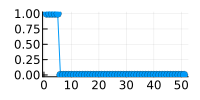

In [103]:
plot(exp.(-750:1:-700) .== 0.0, marker=:o,legend=nothing, size=(200,100))

52.38058462963838
1.0
1.0
1.0
1.0


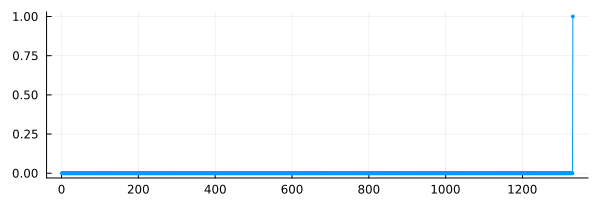

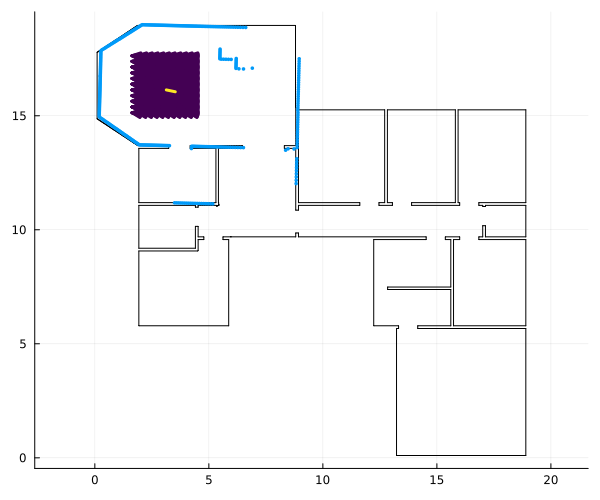

In [105]:

t = 3

ũ = control_prior_model(0.25, 5/180*π)
p0 = _ps[t] + ũ
v0 = Vector(p0)
k = [11,11,11]
r = [0.25,0.25,5/180*π]
grid_args = (v0, k, r)

vs, = vector_grid(grid_args...)
ps  = stack(vs[:])
x   = _ys[t]


ps_ = CuArray(stack(vs[:]))
x_  = CuArray(stack(x))

as_ = CuArray(_as)

w           = 10
s_noise     = 0.1
outlier     = 1e-1
outlier_vol = 1e2
zmax        = 100.0
sensor_args = (w, s_noise, outlier, outlier_vol, zmax)

log_ps, ps = eval_pose_vectors(ps_, x_, _segs, as_, sensor_args...; sorted=true);
ps = Pose.(ps)



ells = log_ps .- maximum(log_ps)
vals = exp.(ells .- logsumexp(ells))
probs  = exp.(log_ps .- logsumexp(log_ps))
probs2 = softmax(log_ps)

println(logsumexp(log_ps))
println(maximum(exp.(log_ps .- logsumexp(log_ps) )))
println(maximum(probs))
println(maximum(exp.(log_ps)/sum(exp.(log_ps))))
println(maximum(softmax(log_ps)))

# -----------------------------
mypl = plot(vals, size=(600,200), marker=:o, markerstrokewidth=0, markersize=2, label=nothing)
display(mypl)
# -----------------------------
mypl = plot(size=(600,500), legend=nothing, aspect_ratio=:equal)
plot!(_segs, c=:black)
cs = cgrad(:viridis)[peak_to_peak(vals)]
plot!(ps, cs; r=.4, linewidth=3)
scatter!(x .* ps[end], markerstrokewidth=0, c=col[1], markersize=2)
# plot!(_ps[t],c=:red, linewidth=3)
display(mypl)